✅ Synthetic data generated and saved!
   Time points: 1000
   Voltage range: -65.0 to 0.0 mV
   m_true range:  0.050 to 0.974


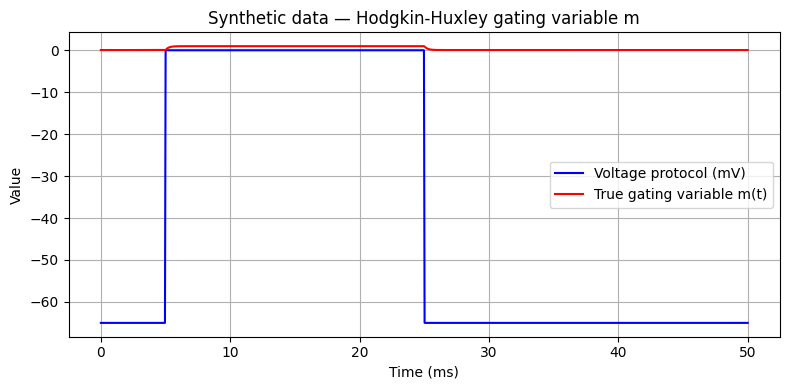

In [2]:
import os
os.makedirs('data', exist_ok=True)   # ← THIS LINE FIXES THE ERROR

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# ==================== HODGKIN-HUXLEY GATING VARIABLE 'm' ====================
def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def dm_dt(m, t, V_func):
    """dm/dt = α(1-m) - βm"""
    V = V_func(t)
    return alpha_m(V) * (1 - m) - beta_m(V) * m

# Voltage step protocol
def voltage_protocol(t):
    if 5 < t < 25:
        return 0.0
    return -65.0

# Generate data
t = np.linspace(0, 50, 1000)
V_array = np.array([voltage_protocol(ti) for ti in t])
m0 = [0.05]
m_true = odeint(dm_dt, m0, t, args=(voltage_protocol,))[:, 0]

# Save dataset
np.savez('data/synthetic_m.npz', t=t, V=V_array, m_true=m_true)

print("✅ Synthetic data generated and saved!")
print(f"   Time points: {len(t)}")
print(f"   Voltage range: {V_array.min():.1f} to {V_array.max():.1f} mV")
print(f"   m_true range:  {m_true.min():.3f} to {m_true.max():.3f}")

# Plot
plt.figure(figsize=(8, 4))
plt.plot(t, V_array, 'b-', label='Voltage protocol (mV)')
plt.plot(t, m_true, 'r-', label='True gating variable m(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.title('Synthetic data — Hodgkin-Huxley gating variable m')
plt.tight_layout()
plt.show()

✅ Data loaded!
   Time points: 1000
   Training on (t, V) → m(t)
🚀 Training data-driven baseline (no physics)...
   Epoch    0 | Loss: 10.756945
   Epoch  400 | Loss: 0.016379
   Epoch  800 | Loss: 0.003248
   Epoch 1200 | Loss: 0.003098
   Epoch 1600 | Loss: 0.003314


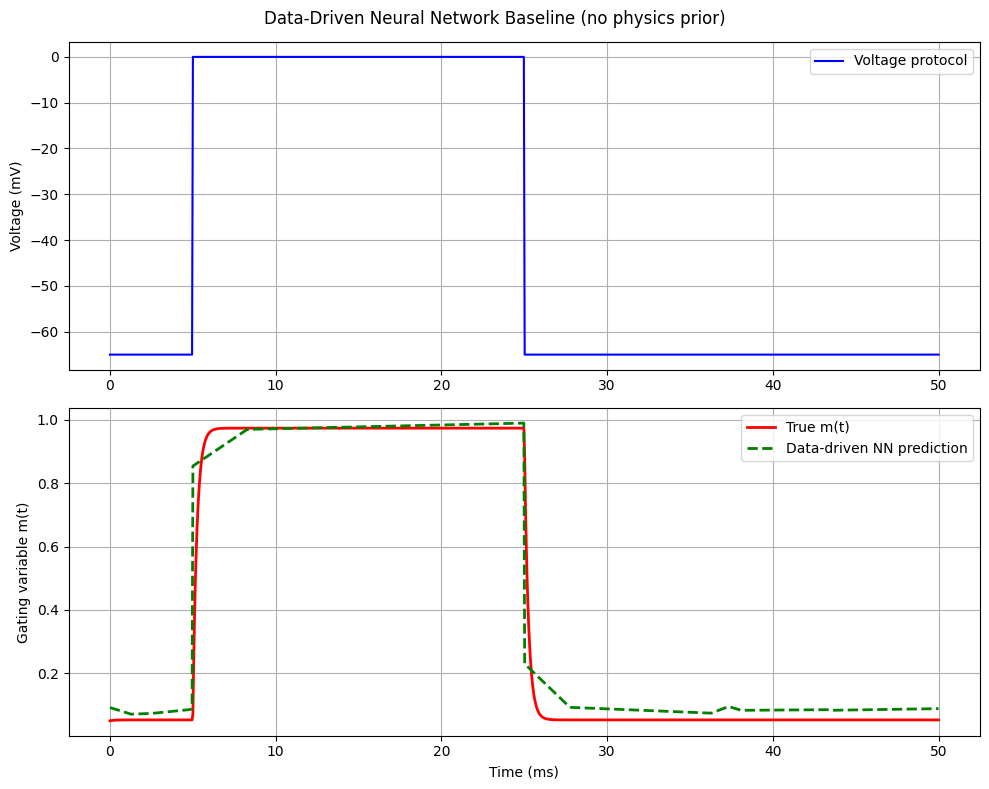

✅ Training complete! Plot saved to outputs/02_data_driven_baseline.png
   Final MSE: 0.003705


In [3]:
import os
os.makedirs('outputs', exist_ok=True)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==================== LOAD SYNTHETIC DATA ====================
data = np.load('data/synthetic_m.npz')
t = data['t']
V = data['V']
m_true = data['m_true']

print("Data loaded!")
print(f"   Time points: {len(t)}")
print(f"   Training on (t, V) → m(t)")

# Prepare tensors
X = torch.tensor(np.stack([t, V], axis=1), dtype=torch.float32)  # shape: (1000, 2)
y = torch.tensor(m_true, dtype=torch.float32).unsqueeze(1)        # shape: (1000, 1)

# ==================== SIMPLE DATA-DRIVEN NN ====================
class DataDrivenNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = DataDrivenNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==================== TRAINING LOOP ====================
epochs = 2000
losses = []

print("Training data-driven baseline (no physics)...")
for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 400 == 0:
        print(f"   Epoch {epoch:4d} | Loss: {loss.item():.6f}")

# ==================== PLOTS ====================
m_pred = model(X).detach().numpy().flatten()

fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(t, V, 'b-', label='Voltage protocol')
axs[0].set_ylabel('Voltage (mV)')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(t, m_true, 'r-', label='True m(t)', linewidth=2)
axs[1].plot(t, m_pred, 'g--', label='Data-driven NN prediction', linewidth=2)
axs[1].set_xlabel('Time (ms)')
axs[1].set_ylabel('Gating variable m(t)')
axs[1].legend()
axs[1].grid(True)

plt.suptitle('Data-Driven Neural Network Baseline (no physics prior)')
plt.tight_layout()
plt.savefig('outputs/02_data_driven_baseline.png', dpi=200)
plt.show()

print("Training complete! Plot saved to outputs/02_data_driven_baseline.png")
print(f"   Final MSE: {losses[-1]:.6f}")